In [1]:
import matplotlib.pyplot as pt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib as mpl


In [176]:
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = True

In [2]:
#dataset preparation with lag
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
#locally weighted regression
def lwr(inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    for i in range(m):
        ypred[i] = inp[i] * beta(inp[i], inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def lwr1(x0, inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    ypred = x0 * beta(x0, inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def beta(point, inp, out, k):
    wt = kernal(point, inp, k)
    #print("The weight of betas is",wt)
    beta_val = (inp.T * (wt*inp)).I * inp.T * wt * out
    #print("The weight is beta value is",beta_val)
    return beta_val

def kernal(point, inp, k):
    l,b = np.shape(inp)
    weights = np.mat(np.eye((l)))
    #print(weights)    
    for i in range(l):
        #print(point.shape,inp[i].shape)
        diff = point - inp[i]
        weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
    return weights

In [117]:
df = pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv',header=0,parse_dates=True,index_col=0)
df.drop(["Present Storage(TMC)",'Reservoir Level(TMC)','Outflow'],axis = 1,inplace = True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)
reshaped=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
print(reshaped.shape)
idx = pd.date_range('2011-01-01', '2018-12-31') 
reshaped['Dates']=idx#reshaped.set_index(idx)
# reshaped.index.name='Dates'
reshaped.head()


(2922, 4)


,Inflow,MADIKERI,SOMWARPET,VIRAJPET,Dates
0,0.001823,0.0,0.0,0.0,2011-01-01
1,0.003068,0.0,0.0,0.0,2011-01-02
2,0.002131,0.0,0.0,0.0,2011-01-03
3,0.001515,0.0,0.0,0.0,2011-01-04
4,0.001669,0.0,0.0,0.0,2011-01-05


In [118]:
#df = pd.read_csv('kodaguAllYearRainDam.csv')
# df = pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv')
print(type(reshaped))
df=reshaped
print(df.head())
a = "RCDATE"
b = "Dates"
df['month'] = pd.DatetimeIndex(df[b]).month
df['year'] = pd.DatetimeIndex(df[b]).year
mask = (df['month'] <= 12)
mask1 = (df['year'] == 2013)
df = df.loc[mask]
print("mask ",df)
df = df.loc[mask1]
print("mask1 ",df)
df.set_index(b,inplace = True)
df.drop(['month','year'],axis = 1,inplace = True)
#df.drop(['Inflow'],axis = 1,inplace = True)
df

<class 'pandas.core.frame.DataFrame'>
     Inflow  MADIKERI  SOMWARPET  VIRAJPET      Dates
0  0.001823       0.0        0.0       0.0 2011-01-01
1  0.003068       0.0        0.0       0.0 2011-01-02
2  0.002131       0.0        0.0       0.0 2011-01-03
3  0.001515       0.0        0.0       0.0 2011-01-04
4  0.001669       0.0        0.0       0.0 2011-01-05
mask          Inflow  MADIKERI  SOMWARPET  VIRAJPET      Dates  month  year
0     0.001823       0.0        0.0       0.0 2011-01-01      1  2011
1     0.003068       0.0        0.0       0.0 2011-01-02      1  2011
2     0.002131       0.0        0.0       0.0 2011-01-03      1  2011
3     0.001515       0.0        0.0       0.0 2011-01-04      1  2011
4     0.001669       0.0        0.0       0.0 2011-01-05      1  2011
...        ...       ...        ...       ...        ...    ...   ...
2917  0.001322       0.0        0.0       0.0 2018-12-27     12  2018
2918  0.001258       0.0        0.0       0.0 2018-12-28     12  2018
29

,Inflow,MADIKERI,SOMWARPET,VIRAJPET
Dates,,,,
2013-01-01,0.001754,0.030020,0.051782,0.000000
2013-01-02,0.001726,0.030504,0.052617,0.000000
2013-01-03,0.001698,0.030988,0.053452,0.000000
2013-01-04,0.001670,0.031473,0.054287,0.000000
2013-01-05,0.001643,0.031957,0.055122,0.000000
...,...,...,...,...
2013-12-27,0.000154,0.061613,0.013681,0.003150
2013-12-28,0.000154,0.061363,0.013899,0.003129
2013-12-29,0.000244,0.061112,0.014116,0.003109


In [218]:
lag_val = 4

In [219]:
values = df.values
values = values.astype('float32')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# data=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# print(data.shape)
# idx = pd.date_range('2011-01-01', '2011-12-31') 
# data.set_index(idx)
# frame as supervised learning
reframed = series_to_supervised(values, lag_val, 1)#lag of 4 days
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()


,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
4,0.001754,0.030020,0.051782,0.0,0.001726,0.030504,0.052617,0.0,0.001698,0.030988,0.053452,0.0,0.001670,0.031473,0.054287,0.0,0.001643
5,0.001726,0.030504,0.052617,0.0,0.001698,0.030988,0.053452,0.0,0.001670,0.031473,0.054287,0.0,0.001643,0.031957,0.055122,0.0,0.001615
6,0.001698,0.030988,0.053452,0.0,0.001670,0.031473,0.054287,0.0,0.001643,0.031957,0.055122,0.0,0.001615,0.032441,0.055958,0.0,0.001587
7,0.001670,0.031473,0.054287,0.0,0.001643,0.031957,0.055122,0.0,0.001615,0.032441,0.055958,0.0,0.001587,0.032925,0.056793,0.0,0.001559
8,0.001643,0.031957,0.055122,0.0,0.001615,0.032441,0.055958,0.0,0.001587,0.032925,0.056793,0.0,0.001559,0.033409,0.057628,0.0,0.001531


In [220]:
values = reframed.values
train_x = values[:,:-1]
print(train_x)
Inflow = values[:,-1]
Inflow = Inflow.reshape((train_x.shape[0],1))

Inflow.shape
train_x.shape

[[0.0017542  0.0300201  0.05178159 ... 0.03147269 0.05428715 0.        ]
 [0.00172629 0.0305043  0.05261678 ... 0.03195689 0.05512234 0.        ]
 [0.00169839 0.0309885  0.05345196 ... 0.03244108 0.05595753 0.        ]
 ...
 [0.00014121 0.06211394 0.01324609 ... 0.06136251 0.01389866 0.00312939]
 [0.00014121 0.06186346 0.01346362 ... 0.06111203 0.01411619 0.0031092 ]
 [0.00015404 0.06161299 0.01368114 ... 0.06086155 0.01433371 0.00308901]]


(361, 16)

In [221]:
#df1 = pd.read_csv('kodaguAllYearRainDam.csv')
df1 =reshaped
df1['month'] = pd.DatetimeIndex(df1[b]).month
df1['year'] = pd.DatetimeIndex(df1[b]).year
df1
mask = (df1['month'] <= 12)
mask1 = (df1['year'] > 2013)#&(df1['year'] <= 2018))
df1 = df1.loc[mask]
df1 = df1.loc[mask1]
df1.set_index(b,inplace = True)
df1.drop(['month','year'],axis = 1,inplace = True)
#df1.drop(['Inflow'],axis = 1,inplace = True)
df1

,Inflow,MADIKERI,SOMWARPET,VIRAJPET
Dates,,,,
2014-01-01,0.000116,0.060361,0.014769,0.003049
2014-01-02,0.000488,0.060110,0.014986,0.003028
2014-01-03,0.001617,0.059860,0.015204,0.003008
2014-01-04,0.001617,0.059609,0.015421,0.002988
2014-01-05,0.001797,0.059359,0.015639,0.002968
...,...,...,...,...
2018-12-27,0.001322,0.000000,0.000000,0.000000
2018-12-28,0.001258,0.000000,0.000000,0.000000
2018-12-29,0.001309,0.000000,0.000000,0.000000


In [222]:
values1 = df1.values
values1 = values1.astype('float32')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values1)
# data1=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# print(data1.shape)
# idx = pd.date_range('2012-01-01', '2018-12-31') 
# data1.set_index(idx)
# frame as supervised learning
reframed1 = series_to_supervised(values1, lag_val, 1)#lag of 4 days
# drop columns we don't want to predict1
print(reframed1.head())
reframed1.drop(reframed1.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed1.head()


   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var1(t-3)  var2(t-3)  \
4   0.000116   0.060361   0.014769   0.003049   0.000488   0.060110   
5   0.000488   0.060110   0.014986   0.003028   0.001617   0.059860   
6   0.001617   0.059860   0.015204   0.003008   0.001617   0.059609   
7   0.001617   0.059609   0.015421   0.002988   0.001797   0.059359   
8   0.001797   0.059359   0.015639   0.002968   0.001746   0.059108   

   var3(t-3)  var4(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  \
4   0.014986   0.003028   0.001617   0.059860   0.015204   0.003008   
5   0.015204   0.003008   0.001617   0.059609   0.015421   0.002988   
6   0.015421   0.002988   0.001797   0.059359   0.015639   0.002968   
7   0.015639   0.002968   0.001746   0.059108   0.015856   0.002948   
8   0.015856   0.002948   0.001752   0.058858   0.016074   0.002927   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
4   0.001617   0.059609   0.015421   0.002988  0.001797  0.059359  

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
4,0.000116,0.060361,0.014769,0.003049,0.000488,0.060110,0.014986,0.003028,0.001617,0.059860,0.015204,0.003008,0.001617,0.059609,0.015421,0.002988,0.001797
5,0.000488,0.060110,0.014986,0.003028,0.001617,0.059860,0.015204,0.003008,0.001617,0.059609,0.015421,0.002988,0.001797,0.059359,0.015639,0.002968,0.001746
6,0.001617,0.059860,0.015204,0.003008,0.001617,0.059609,0.015421,0.002988,0.001797,0.059359,0.015639,0.002968,0.001746,0.059108,0.015856,0.002948,0.001752
7,0.001617,0.059609,0.015421,0.002988,0.001797,0.059359,0.015639,0.002968,0.001746,0.059108,0.015856,0.002948,0.001752,0.058858,0.016074,0.002927,0.001759
8,0.001797,0.059359,0.015639,0.002968,0.001746,0.059108,0.015856,0.002948,0.001752,0.058858,0.016074,0.002927,0.001759,0.058607,0.016291,0.002907,0.001528


In [223]:
values1 = reframed1.values
Actuall_inflow = values1[:,-1]
test_x = values1[:,:-1]

print(train_x.shape,Inflow.shape)
print(test_x.shape)
Actuall_inflow.shape

(361, 16) (361, 1)
(1822, 16)


(1822,)

In [224]:
ypred = []
train_X = train_x
train_y = Inflow
for i in test_x:
    ypred.append(lwr1(i, train_X, train_y, 7.15))
ypred = np.array(ypred).reshape(Actuall_inflow.shape[0],1)

In [225]:
ypred

array([[0.00245368],
       [0.00294777],
       [0.00286797],
       ...,
       [0.00109794],
       [0.00115749],
       [0.00110945]])

In [226]:
Actuall_inflow=Actuall_inflow.reshape(Actuall_inflow.shape[0],1)

In [227]:
inv_yhat = np.concatenate((ypred, test_x[:, -3:]), axis=1)
out=scaler.inverse_transform(inv_yhat) 
out=out[:,0]
tar_y = np.concatenate((Actuall_inflow, test_x[:, -3:]), axis=1)
tar=scaler.inverse_transform(tar_y)
tar=tar[:,0]

In [228]:
print("MSE = ",metrics.mean_squared_error(tar,out))
print("RMSE = ",sqrt(metrics.mean_squared_error(tar,out)))
print("RMSE = ",sqrt(metrics.mean_squared_error(tar[:-1],out[1:])))

MSE =  3035485.0568394614
RMSE =  1742.2643475774453
RMSE =  901.7335837138183


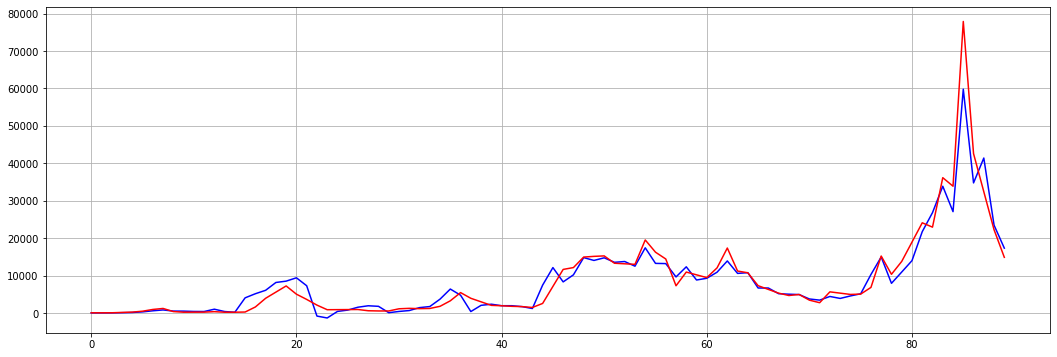

In [231]:
pt.plot(out[1601:1691],c='blue')
pt.plot(tar[1600:1690],c='red')

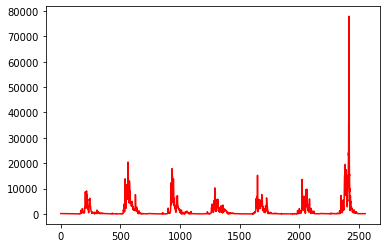

In [125]:
pt.plot(tar,c='red')

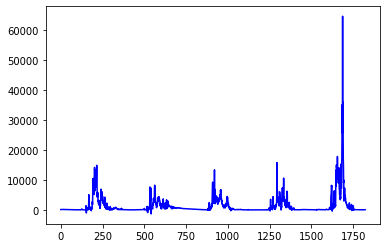

In [172]:
pt.plot(out,c='blue')